In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import lightgbm as lgb
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()

'/Users/oscar.martinez/Library/CloudStorage/OneDrive-CoxAutomotive/Documents/GT/MGT6203/Project'

In [ ]:
np.random.seed(123456789)

In [41]:
# import the data
df_2014 = pd.read_csv('stock_financial_data/2014_Financial_Data.csv')
df_2014['year'] = 2014

df_2015 = pd.read_csv('stock_financial_data/2015_Financial_Data.csv')
df_2015['year'] = 2015

df_2016 = pd.read_csv('stock_financial_data/2016_Financial_Data.csv')
df_2016['year'] = 2016

df_2017 = pd.read_csv('stock_financial_data/2017_Financial_Data.csv')
df_2017['year'] = 2017

df_2018 = pd.read_csv('stock_financial_data/2018_Financial_Data.csv')
df_2018['year'] = 2018

# rename a column so we can append
for df in [df_2014, df_2015, df_2016, df_2017, df_2018]:
    df.columns = ['PRICE VAR' if 'PRICE VAR' in x else x for x in list(df.columns)]
    df.rename(columns={'Unnamed: 0':'company'}, inplace=True)

In [42]:
# concatenate/append data together
df = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018], ignore_index=True)

# delete the uneeded data frames to free up memory
del [df_2014, df_2015, df_2016, df_2017, df_2018]

In [46]:
# indicator to denote if this is for the final evaluation or not
final = 1

# fraction to test-train on
test_frac = 0.25

if final == 1:
    # drop rows that are missing our two dependent variables
    df.dropna(subset=['PRICE VAR','Class'], inplace=True)

    # create a helper df to help keep only the companies that have entries across all years
    val_df = pd.DataFrame(df['company'].value_counts()).reset_index()

    # list with the companies that we shoiuld keep
    co_keep_list = list(val_df.loc[val_df['count']==5, 'company'].unique())
    
    # keep only the companies that satisfy our filtering criteria
    df = df.loc[df['company'].isin(co_keep_list), :].copy()    
    
    # subset the final list of columns roughly in half for training and testing
    test_cos = np.random.choice(co_keep_list, size = int(np.ceil(len(co_keep_list)*test_frac)), replace=False)
    
    # indicate whether we are testing or training with these models
    df['test'] = 0
    df.loc[df['company'].isin(test_cos), 'test'] = 1

In [47]:
df['test'].value_counts()

test
0    13970
1     4660
Name: count, dtype: int64

In [48]:
# one-hot encoding sector variable
df = pd.get_dummies(df, columns=['Sector'])

In [49]:
[x for x in list(df.columns) if 'market' in x.lower()]

['Net Cash/Marketcap', 'Market Cap']

In [50]:
df[['Market Cap']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 18630 entries, 0 to 22073
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Market Cap  17384 non-null  float64
dtypes: float64(1)
memory usage: 291.1 KB


In [51]:
# gbm models do not support special json charcters as feature names
df.columns = [x.replace(' ', '_').replace('(', '').replace(')','').replace('&', '_and_')\
              .replace('/', '-').replace('\\', '').replace(',','') for x in  list(df.columns)]

## Numerical predictor

In [52]:
# Split the data
if final == 0:
    # drop company name as well as 'PRICE VAR','Class' which are what we're trying to predict and a sector to prevent perfect multicollinearity
    X = df.drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year']).copy() # dropped a sector to not have perfect collinearity    
    
    # define what we are trying to predict
    y=df['PRICE_VAR'].copy()    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123456789
    )
elif final == 1:
    # dropped a sector to not have perfect collinearity    
    X_train = df.loc[df['test']==0, :].drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year', 'test']).copy()
    X_test = df.loc[df['test']==1, :].drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year', 'test']).copy()
    y_train = df.loc[df['test']==0, 'PRICE_VAR'].copy()
    y_test = df.loc[df['test']==1, 'PRICE_VAR'].copy()
    
    # create an info df to be able to piece back the info
    info_train = df.loc[df['test']==0, ['company', 'year', 'test']].copy()    
    info_test = df.loc[df['test']==1, ['company', 'year', 'test']].copy()

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',  # for regression problems
    'metric': 'rmse',          # evaluation metric
    'num_leaves': 31,          # max number of leaves in one tree
    'learning_rate': 0.05,     # learning rate
    'feature_fraction': 0.9,   # fraction of features to use in each iteration
    'bagging_fraction': 0.8,   # fraction of data to use for each iteration
    'bagging_freq': 5,         # perform bagging every k iterations
    'verbose': -1              # suppress printing
}

# Train model
model = lgb.train(
    params,
    train_data
)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [53]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

In [54]:
feature_importance.head(25)

,feature,importance
152,Earnings_Yield,278
153,Free_Cash_Flow_Yield,228
172,Graham_Net-Net,182
140,Market_Cap,139
151,EV_to_Free_cash_flow,123
141,Enterprise_Value,102
86,priceFairValue,79
164,Intangibles_to_Total_Assets,73
16,EPS,71
74,Net_Cash-Marketcap,70


In [116]:
feature_importance.to_csv('numeric_feature_importance.csv', index=False)

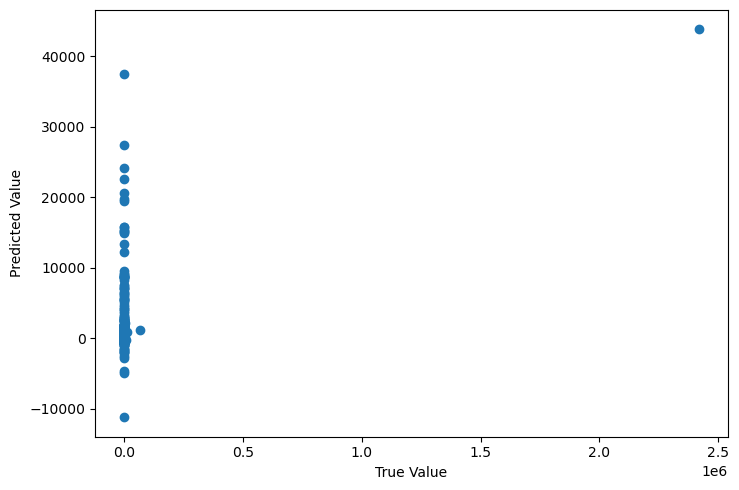

In [55]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))
ax.scatter(y_test, y_pred)
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
fig.tight_layout()

## Binary Classifier

In [80]:
# Split the data
if final == 0:
    # drop company name as well as 'PRICE VAR','Class' which are what we're trying to predict and a sector to prevent perfect multicollinearity
    X = df.drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year']).copy() # dropped a sector to not have perfect collinearity    
    
    # define what we are trying to predict
    y=df['Class'].copy()    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123456789
    )
elif final == 1:
    # dropped a sector to not have perfect collinearity    
    X_train = df.loc[df['test']==0, :].drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year', 'test']).copy()
    X_test = df.loc[df['test']==1, :].drop(columns=['company','PRICE_VAR','Class','Sector_Technology', 'year', 'test']).copy()
    y_train = df.loc[df['test']==0, 'Class'].copy()
    y_test = df.loc[df['test']==1, 'Class'].copy()
    
    # create an info df to be able to piece back the info
    info_train = df.loc[df['test']==0, ['company', 'year', 'test', 'Class', 'PRICE_VAR']].copy()    
    info_test = df.loc[df['test']==1, ['company', 'year', 'test', 'Class', 'PRICE_VAR']].copy()    

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',  # for regression problems
    'metric': 'binary_logloss',          # evaluation metric
    'num_leaves': 31,          # max number of leaves in one tree
    'learning_rate': 0.05,     # learning rate
    'feature_fraction': 0.9,   # fraction of features to use in each iteration
    'bagging_fraction': 0.8,   # fraction of data to use for each iteration
    'bagging_freq': 5,         # perform bagging every k iterations
    'verbose': -1              # suppress printing
}

# Train model
model = lgb.train(
    params,
    train_data
)

# Make predictions
y_pred = model.predict(X_test)
y_pred_raw = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc_roc': roc_auc_score(y_test, y_pred)
}

In [81]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

In [82]:
feature_importance.head(25)

,feature,importance
71,Effect_of_forex_changes_on_cash,72
58,Other_Assets,51
197,Operating_Cash_Flow_growth,44
217,Book_Value_per_Share_Growth,44
57,Net_Debt,38
95,returnOnAssets,37
195,Weighted_Average_Shares_Diluted_Growth,37
153,Free_Cash_Flow_Yield,37
89,niperEBT,37
18,Weighted_Average_Shs_Out,37


In [83]:
feature_importance.to_csv('binary_feature_importance.csv', index=False)

In [84]:
# fig, ax = plt.subplots(1,1, figsize=(7.5,5))
# ax.scatter(y_test, y_pred)
# ax.set_xlabel('True Value')
# ax.set_ylabel('Predicted Value')
# fig.tight_layout()

In [85]:
metrics

{'accuracy': 0.6371244635193133,
 'precision': 0.6492587601078167,
 'recall': 0.7477687233216919,
 'f1': 0.6950405770964834,
 'auc_roc': 0.6240043808639184}

In [86]:
np.ones(y_test.shape)

array([1., 1., 1., ..., 1., 1., 1.])

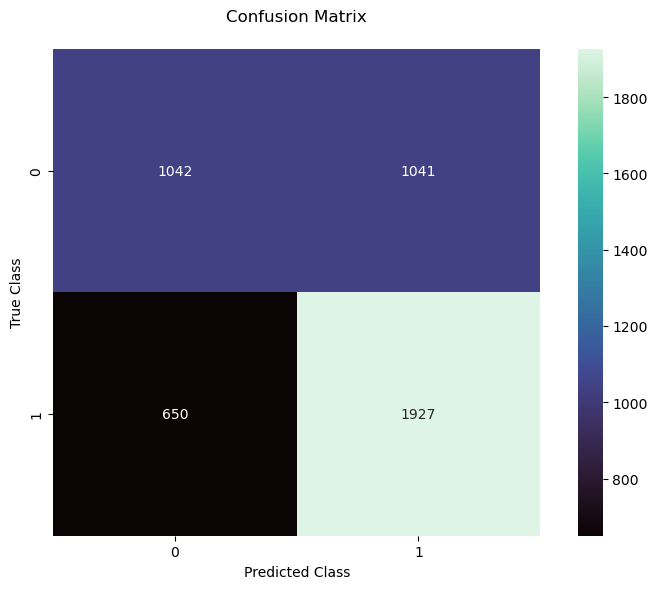

In [87]:
# Calculate confusion matrix
# cm = confusion_matrix(np.ones(y_test.shape), y_pred) # created a vector of ones to make sure I am labeling the figure correctly
cm = confusion_matrix(y_test, y_pred)

# Create figure and axes
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(cm, 
            annot=True,           # Show numbers in cells
            fmt='d',             # Format as integers
            cbar=True,           # Show color bar
            cmap = sns.color_palette("mako", as_cmap=True),
            square=True)         # Make cells square

# plt.xticks(np.arange(2) + 0.5, ['Negative', 'Positive'], rotation=45)
# plt.yticks(np.arange(2) + 0.5, ['Negative', 'Positive'], rotation=0)

# Customize the plot
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Adjust layout
plt.tight_layout()

In [88]:
y_test

0        0
2        1
5        1
7        0
15       1
        ..
22051    1
22052    1
22057    0
22070    1
22072    0
Name: Class, Length: 4660, dtype: int64

In [89]:
y_pred_raw

array([0.79724909, 0.57737226, 0.81118932, ..., 0.50256442, 0.53728926,
       0.45887412])

In [90]:
info_test['lgb_pred'] = y_pred_raw
info_test['lgb_keep'] = y_pred

In [92]:
info_test

,company,year,test,Class,PRICE_VAR,lgb_pred,lgb_keep
0,PG,2014,1,0,-9.323276,0.797249,1
2,KR,2014,1,1,33.118297,0.577372,1
5,PM,2014,1,1,13.980937,0.811189,1
7,WMT,2014,1,0,-26.653702,0.520885,1
15,KMB,2014,1,1,13.745829,0.803558,1
...,...,...,...,...,...,...,...
22051,VTNR,2018,1,1,25.203247,0.378031,0
22052,VVUS,2018,1,1,16.239322,0.439514,0
22057,WHLM,2018,1,0,-28.987994,0.502564,1
22070,XELB,2018,1,1,27.118650,0.537289,1


In [93]:
info_test.to_csv('final_predictions_lgbm.csv')

In [110]:
pd.DataFrame(zip(y_test, y_pred), columns=['True','Predicted']).to_csv('test_data_predictions.csv')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22077 entries, 0 to 22076
Columns: 235 entries, company to Sector_Utilities
dtypes: bool(11), float64(222), int64(1), object(1)
memory usage: 38.0+ MB
